In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
!pip install -q gdown


In [1]:
import torchvision.transforms as T
from torchvision.datasets import Cityscapes
from torch.utils.data import DataLoader
from PIL import Image
import torch
import numpy as np
from torch.utils.data import Subset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torchvision.models.segmentation as seg_models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import cv2
import gc
from torchvision.transforms.functional import to_pil_image

from sklearn.metrics import roc_auc_score, average_precision_score
from torch.utils.data import random_split


from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize
from google.colab.patches import cv2_imshow

from __future__ import print_function, absolute_import, division
from collections import namedtuple
import os


# Constants

In [2]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_transform = T.Compose([
    T.Resize((512, 1024)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])


Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

# FOR CITYSCAPES DATASET
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


name2label      = { label.name    : label for label in labels           }
id2label        = { label.id      : label for label in labels           }
trainId2label   = { label.trainId : label for label in reversed(labels) }

# FOR LOST AND FOUND DATASET
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


labels = [
    #       name                     id      trainId    hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,       0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  0 ,       0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  0 ,       0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  0 ,       0       , False        , True         , (  0,  0,  0) ),
    Label(  'background'           ,  0 ,       0       , False        , False        , (  0,  0,  0) ),
    Label(  'free'                 ,  1 ,       1       , False        , False        , (128, 64,128) ),
    Label(  '01'                   ,  2 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '02'                   ,  3 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '03'                   ,  4 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '04'                   ,  5 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '05'                   ,  6 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '06'                   ,  7 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '07'                   ,  8 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '08'                   ,  9 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '09'                   , 10 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '10'                   , 11 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '11'                   , 12 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '12'                   , 13 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '13'                   , 14 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '14'                   , 15 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '15'                   , 16 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '16'                   , 17 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '17'                   , 18 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '18'                   , 19 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '19'                   , 20 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '20'                   , 21 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '21'                   , 22 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '22'                   , 23 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '23'                   , 24 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '24'                   , 25 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '25'                   , 26 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '26'                   , 27 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '27'                   , 28 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '28'                   , 29 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '29'                   , 30 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '30'                   , 31 ,       0       , True         , False        , (  0,  0,  0) ),
    Label(  '31'                   , 32 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '32'                   , 33 ,       0       , True         , False        , (  0,  0,  0) ),
    Label(  '33'                   , 34 ,       0       , True         , False        , (  0,  0,  0) ),
    Label(  '34'                   , 35 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '35'                   , 36 ,       0       , True         , False        , (  0,  0,  0) ),
    Label(  '36'                   , 37 ,       0       , True         , False        , (  0,  0,  0) ),
    Label(  '37'                   , 38 ,       0       , True         , False        , (  0,  0,  0) ),
    Label(  '38'                   , 39 ,       0       , True         , False        , (  0,  0,  0) ),
    Label(  '39'                   , 40 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '40'                   , 41 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '41'                   , 42 ,       2       , True         , False        , (  0,  0,142) ),
    Label(  '42'                   , 43 ,       2       , True         , False        , (  0,  0,142) ),
]

id2label_lf        = { label.id      : label for label in labels           }



# Utils

In [3]:

def target_transform(label):
    label = torch.from_numpy(np.array(label)).long()
    return label

In [4]:

def prepare_targets(label, sorted_keys, sorted_train_ids, output_size=(64, 128)):
    label = vectorized_map_labels(label, sorted_keys, sorted_train_ids)

    label[label == 255] = 19

    one_hot = F.one_hot(label, num_classes=21)
    one_hot = one_hot.permute(0, 3, 1, 2).float().to(device)

    mask = ((label > 10) & (label < 19)).unsqueeze(1)

    one_hot[:, 20:21] = mask.float()
    one_hot = F.interpolate(one_hot.float(), size=output_size, mode='nearest').long().squeeze(1)

    return one_hot

def prepare_targets_lf(label, sorted_keys, sorted_train_ids, output_size=(64, 128), device='cpu'):
    label = vectorized_map_labels(label, sorted_keys, sorted_train_ids)
    object_mask = ((label == 2) ).long()             # (B, H, W)
    object_mask = object_mask.unsqueeze(1)        # (B, 1, H, W)
    object_mask = F.interpolate(object_mask.float(), size=output_size, mode='nearest').long()
    label = F.interpolate(label.unsqueeze(1).float(), size=output_size, mode='nearest').long().squeeze(1)

    return label, object_mask

def vectorized_map_labels(label_tensor, sorted_keys, sorted_train_ids):
    keys_for_label = torch.where(label_tensor < 1000, label_tensor, label_tensor // 1000)

    pos = torch.searchsorted(sorted_keys, keys_for_label.view(-1))

    mapped_flat = torch.full_like(keys_for_label.view(-1), -1)

    valid_mask = (pos < len(sorted_keys)) & (sorted_keys[pos] == keys_for_label.view(-1))
    mapped_flat[valid_mask.nonzero(as_tuple=True)[0]] = sorted_train_ids[pos[valid_mask]]

    return mapped_flat.view(label_tensor.shape)

def prepare_label_mapping(id2label, device='cpu'):
    keys = []
    train_ids = []
    for k, v in id2label.items():
        keys.append(k)
        train_ids.append(v.trainId)
    keys = torch.tensor(keys, device=device)
    train_ids = torch.tensor(train_ids, device=device)

    sorted_keys, indices = torch.sort(keys)
    sorted_train_ids = train_ids[indices]

    return sorted_keys, sorted_train_ids

sorted_keys, sorted_train_ids = prepare_label_mapping(id2label, device='cuda' if torch.cuda.is_available() else 'cpu')

sorted_keys_lf, sorted_train_ids_lf = prepare_label_mapping(id2label_lf, device=device)



# Data

In [ ]:
os.makedirs('/content/cityscapes/leftImg8bit', exist_ok=True)

!gdown --id 1XmfVj1sy2V48JiA89P-oDB_5Gazx40i4 -O /content/cityscapes/leftImg8bit.zip
!unzip -q /content/cityscapes/leftImg8bit.zip -d /content/cityscapes/

In [ ]:

os.makedirs('/content/cityscapes/gtFine', exist_ok=True)

!gdown --id 1b7c3eErZuI6SaCQtaTkylsfw_0ONk-Tq -O /content/cityscapes/gtFine.zip
!unzip -q /content/cityscapes/gtFine.zip -d /content/cityscapes/


In [ ]:

os.makedirs('/content/LostAndFound/gtCoarse', exist_ok=True)

!gdown --id 1kV2MGw1gMBPIHOxmahq1lmR1SxNYwI-p -O /content/LostAndFound/gtCoarse.zip
!unzip -q /content/LostAndFound/gtCoarse.zip -d /content/LostAndFound/gtCoarse/


In [ ]:

os.makedirs('/content/LostAndFound/leftImg8bit', exist_ok=True)

!gdown --id 1NMu-y-ZmfdexLLQLwUfKI7idn9Gt79E_ -O /content/LostAndFound/leftImg8bit.zip
!unzip -q /content/LostAndFound/leftImg8bit.zip -d /content/LostAndFound/leftImg8bit/


In [14]:
cityscapes_dataset = Cityscapes(
    root='/content/cityscapes', # Use the path where you downloaded the dataset
    split='train',
    mode='fine',
    target_type='instance',
    transform=input_transform,
    target_transform=target_transform,
)
train_loader = DataLoader(cityscapes_dataset, batch_size=4, shuffle=False)

In [15]:
cityscapes_datase_val = Cityscapes(
    root='/content/cityscapes', # Use the path where you downloaded the dataset
    split='val',
    mode='fine',
    target_type='instance',
    transform=input_transform,
    target_transform=target_transform,
)
val_loader = DataLoader(cityscapes_datase_val, batch_size=4, shuffle=True)

# Model

In [ ]:
!gdown --id 1IXWjnFG4yYFuRJZRSK6YUH-QpJyIUMl- -O best_model.pth

In [5]:

class DualSegmentationModel(nn.Module):
    def __init__(self, n_classes=21):
        super().__init__()
        base_model = seg_models.deeplabv3_resnet50(pretrained=True)
        self.encoder = base_model.backbone
        self.decoder = nn.Conv2d(2048,256,kernel_size=1)
        self.head_semantic = nn.Conv2d(256, n_classes, kernel_size=1)

    def forward(self, x):
        features = self.encoder(x)['out']
        x = self.decoder(features)
        semantic_logits = self.head_semantic(x)
        return semantic_logits


In [6]:
def boundary_aware_bce_loss(logits, targets, boundary_mask, device, lambda_weight = 5,num_classes = 21):
    bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    bce_standard = bce.mean()

    # Boundary-aware loss
    if boundary_mask.shape[1] == 1:
        boundary_mask = boundary_mask.expand_as(bce)
    boundary_loss = (bce * boundary_mask).sum() / (boundary_mask.sum() + 1e-6)

    loss = bce_standard + lambda_weight * boundary_loss
    return loss

def compute_boundary_mask_batch(semantic_labels, kernel_size=3):
    boundary_masks = []
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    for label in semantic_labels.cpu().numpy():
        dilated = cv2.dilate(label.astype(np.uint8), kernel, iterations=1)
        eroded = cv2.erode(label.astype(np.uint8), kernel, iterations=1)
        boundary = (dilated != eroded).astype(np.float32)
        boundary_masks.append(torch.tensor(boundary))

    return torch.stack(boundary_masks).unsqueeze(1).to(semantic_labels.device)



In [7]:

def compute_loss(sem_logits, sem_target, device ,lambda_weight = 5.0):
  sem_target_no_special = sem_target[:, :20, :, :]  # Keep first 20 classes only

  semantic_labels = sem_target_no_special.argmax(dim=1)
  boundary_mask = compute_boundary_mask_batch(semantic_labels)
  sem_loss = boundary_aware_bce_loss(sem_logits, sem_target, boundary_mask, device ,lambda_weight)
  return sem_loss


In [8]:

state_dict = torch.load("/content/best_model.pth", map_location=torch.device(device))
model = DualSegmentationModel()
model.to(device)
model.load_state_dict(state_dict)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:


def validate(model, val_loader, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            sem_target  = prepare_targets(targets.to(device),sorted_keys, sorted_train_ids)

            out_sem = model(images)

            probs = torch.sigmoid(out_sem[:, 20:21, :, :])

            loss = compute_loss(out_sem,sem_target.float(),device, lambda_weight)
            running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)

    print(f"Validation Pixel loss: {avg_loss:.2f}%")
    return  avg_loss

# Train

In [ ]:
num_epochs = 1 # trained the model with 15 epochs

In [ ]:
best_val_loss = float('inf')
patience = 5
lambda_weight = 3
early_stop_counter = 0

save_path_loss = '/content/drive/MyDrive/cityscapes/best_model_loss.pth'
current_path = '/content/drive/MyDrive/cityscapes/current_epoch_model.pth'

# Optimizer & scheduler
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
total_iters = num_epochs * len(train_loader)
scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=total_iters, power=0.9)

scaler = torch.amp.GradScaler(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, targets in loop:
        images = images.to(device)

        sem_target  = prepare_targets(targets.to(device),sorted_keys, sorted_train_ids)

        sem_target = sem_target.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast(device):
            out_sem = model(images)
            loss = compute_loss(out_sem,sem_target.float(),device, lambda_weight)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

        scheduler.step()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")
    torch.save(model.state_dict(), current_path)

    print(f"Model saved (Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f})")


    if epoch == 0 or (epoch + 1) % 3 == 0:
        val_loss = validate(model, val_loader, device)

        if val_loss < best_val_loss:
            best_val_acc = val_loss
            torch.save(model.state_dict(), save_path_loss)
            print(f"Model saved (val_loss={val_loss:.4f})")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"No improvement. Early stop counter: {early_stop_counter}/{patience}")

        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training complete!")


Epoch 1/1: 100%|██████████| 744/744 [13:03<00:00,  1.05s/it, loss=0.217]


Epoch [1/1] Loss: 0.2276
Model saved (Epoch [1/1] Loss: 0.2276)
Validation Pixel loss: 0.04%
No improvement. Early stop counter: 1/5
Training complete!


# Conformalize Setup And Test


In this section i devised a method to use conformal prediction and also test in on a lost and found split available to train. I used some data for calibration and then used the other part for test

In [9]:

cityscapes_dataset = Cityscapes(
    root='/content/LostAndFound',
    split='train_extra',
    mode='coarse',
    target_type='semantic',
    transform=input_transform,
    target_transform=target_transform,
)

total_size = len(cityscapes_dataset)

cal_ratio = 0.5

cal_size = int(cal_ratio * total_size)

test_size = total_size - cal_size

cal_dataset, test_dataset = random_split(cityscapes_dataset, [cal_size, test_size])

cal_loader = DataLoader(cal_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
def miscoverage_loss_single_class(Z_c, Y_c):
    Z_c = Z_c.squeeze()
    Y_c = Y_c.squeeze()
    true_positives = torch.sum(Z_c * Y_c)
    total_positives = torch.sum(Y_c)
    if total_positives == 0:
        return 0.0

    coverage = true_positives / total_positives
    return 1.0 - coverage

def infer_with_lambda(pred_probs, lambda_hat):
    return threshold_predictions(pred_probs, lambda_hat)

In [11]:
def threshold_predictions(pred_probs, threshold):
    return (pred_probs >= threshold).float()

In [12]:
def calibrate_lambda(pred_probs_cal, gt_masks_cal, alpha=0.1, loss_fn=miscoverage_loss_single_class, tol=1e-3):
    lower, upper = 0.0, 1.0
    while upper - lower > tol:
        mid = (lower + upper) / 2
        Z = threshold_predictions(pred_probs_cal, mid)
        losses = loss_fn(Z, gt_masks_cal)
        risk = losses
        if risk > alpha:
            lower = mid
        else:
            upper = mid

    return (lower + upper) / 2

def calibration_loop(model, cal_loader ,device, calibration_point_batch = 10, alpha = 0.1):
    model.eval()
    cal_sgmd_list = []
    cal_gt_list = []
    lambdas = 0
    count = 0

    with torch.no_grad():
        for images, targets in cal_loader:
            images = images.to(device)
            _ , object_target  = prepare_targets_lf(targets.to(device),sorted_keys_lf, sorted_train_ids_lf)
            out_sem = model(images)
            sem_probs = torch.sigmoid(out_sem[:, :20, :, :]).detach().cpu()
            probs = torch.sigmoid(out_sem[:, 20:21, :, :]).cpu()

            sem_probs_inv = 1 - sem_probs
            sem_logits_inv_prod = sem_probs_inv.prod(dim=1)
            unknown_objectness_score = sem_logits_inv_prod.squeeze() * probs.squeeze()

            unk_score = unknown_objectness_score
            unk_score_norm = (unk_score - unk_score.min()) / (unk_score.max() - unk_score.min() + 1e-8)

            lam_hat = calibrate_lambda(unk_score_norm,object_target.cpu(),alpha)
            lambdas += lam_hat
            count += 1
            if count == calibration_point_batch:
                break

    return lambdas/count

In [13]:
avg_lam = calibration_loop(model,cal_loader, device,40)
avg_lam

0.59990234375

In [14]:

def evaluate_model(model, test_loader, device, avg_lam):
    model.eval()
    threshold = avg_lam
    all_preds = []
    all_gts = []
    all_probs = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            sem_target, obj_target = prepare_targets_lf(targets.to(device), sorted_keys_lf, sorted_train_ids_lf)
            out_sem = model(images)

            sem_probs = torch.sigmoid(out_sem[:, :20, :, :]).detach().cpu()
            probs = torch.sigmoid(out_sem[:, 20:21, :, :]).detach().cpu()

            sem_probs_inv = 1 - sem_probs
            sem_logits_inv_prod = sem_probs_inv.prod(dim=1)
            unknown_objectness_score = sem_logits_inv_prod.squeeze() * probs.squeeze()

            unk_score = unknown_objectness_score
            unk_score_norm = (unk_score - unk_score.min()) / (unk_score.max() - unk_score.min() + 1e-8)

            binary_mask = (unk_score_norm > threshold).float()

            gt_mask = obj_target.squeeze().cpu().float()
            pred_mask = binary_mask.squeeze()

            all_preds.append(pred_mask.flatten())
            all_gts.append(gt_mask.flatten())
            all_probs.append(unk_score_norm.flatten())

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_gts).numpy()
    y_scores = torch.cat(all_probs).numpy()

    auroc = roc_auc_score(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    print("Evaluation Metrics:")
    print(f"  AUROC:     {auroc:.4f}")
    print(f"  AP:        {ap:.4f}")

    return {
        'auroc': auroc,
        'ap': ap
    }


In [15]:
evaluate_model(model, test_loader, device, avg_lam)


Evaluation Metrics:
  AUROC:     0.9981
  AP:        0.4736


{'auroc': np.float64(0.9980832515258287), 'ap': np.float64(0.4735716310638767)}

# Visualization

In [ ]:
train_extra_loader = DataLoader(cityscapes_dataset, batch_size=4, shuffle=True)

In [20]:
def visualize_output(train_extra_loader, batches = 5):
  model.eval()
  count = 0
  with torch.no_grad():
    for images, targets in train_extra_loader:
        images = images.to(device)
        sem_target, obj_target = prepare_targets_lf(targets.to(device), sorted_keys_lf, sorted_train_ids_lf)
        out_sem = model(images)
        probs = torch.sigmoid(out_sem[:, 20:21, :, :]).detach().cpu()

        sem_probs = torch.sigmoid(out_sem[:, :20, :, :]).detach().cpu()

        sem_probs_inv = 1 - sem_probs
        sem_logits_inv_prod = sem_probs_inv.prod(dim=1)
        unknown_objectness_score = sem_logits_inv_prod.squeeze() * probs.squeeze()

        plt.figure(figsize=(16, 4))
        obj_target= obj_target.detach().cpu()

        original_rgb = images[0].cpu().numpy().transpose(1, 2, 0)
        original_rgb = original_rgb * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        original_rgb = np.clip(original_rgb, 0, 1)

        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(original_rgb)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Object Probability")
        plt.imshow(probs[0, 0], cmap='hot')
        plt.axis('off')


        plt.subplot(1, 3, 3)
        plt.title("unkown score Probability")
        plt.imshow(unknown_objectness_score[0], cmap='hot')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
        if count == batches:
          break
        count += 1


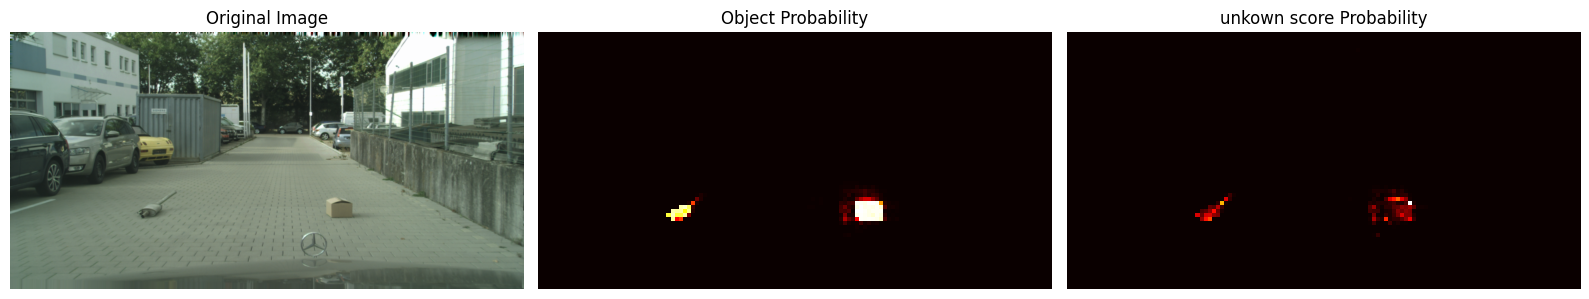

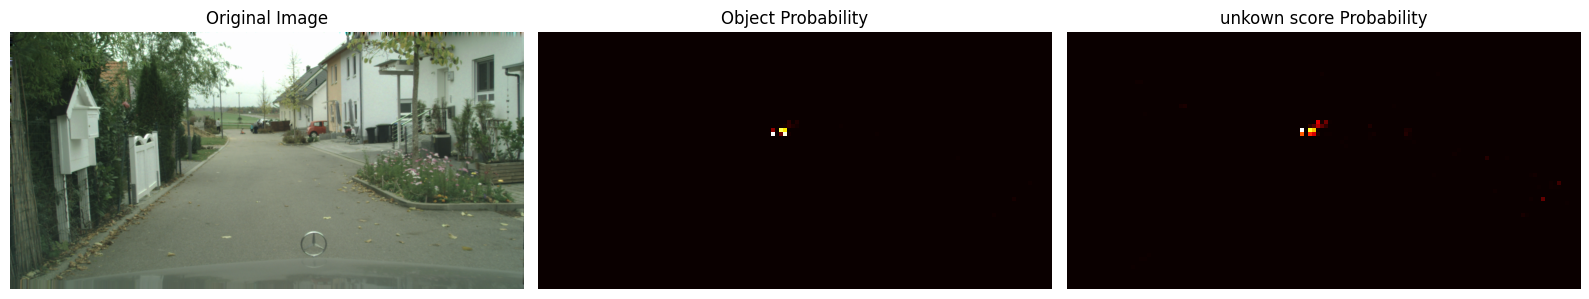

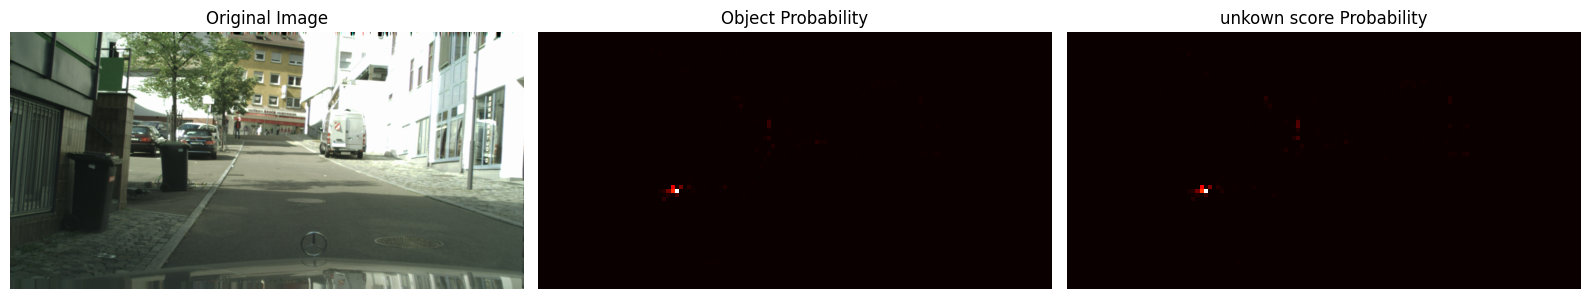

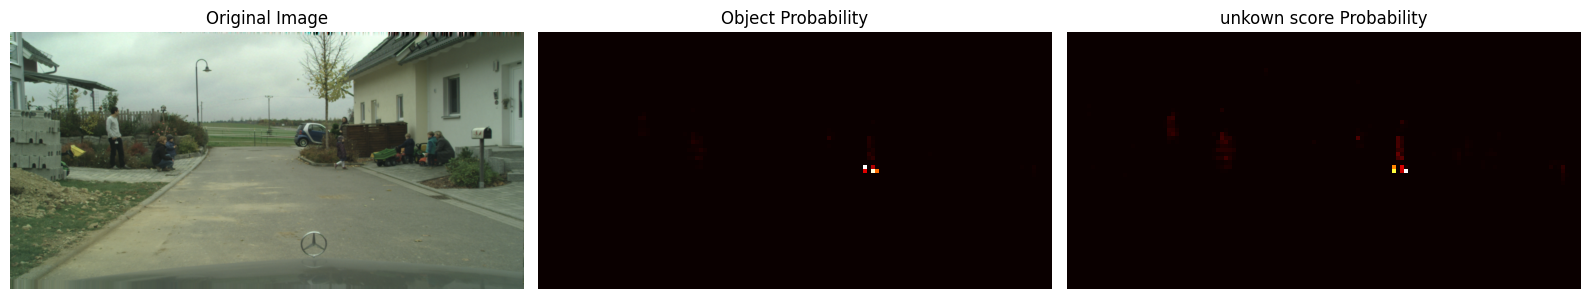

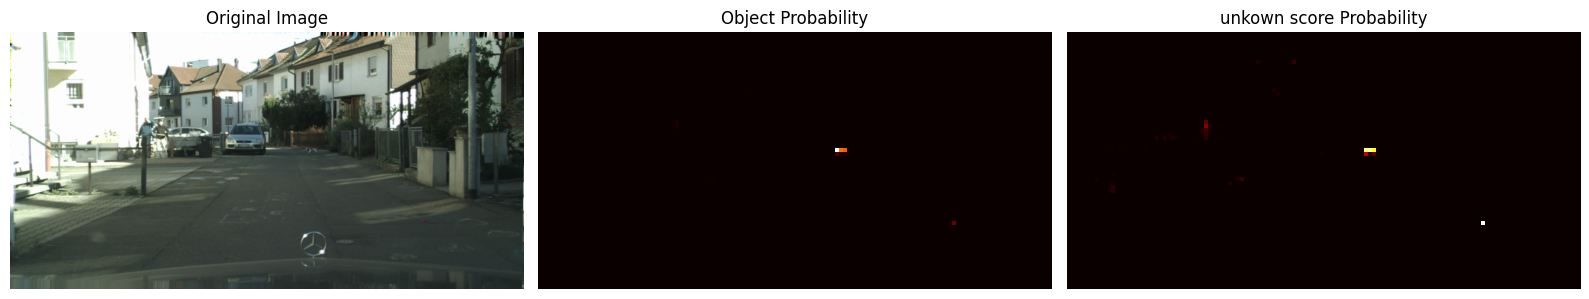

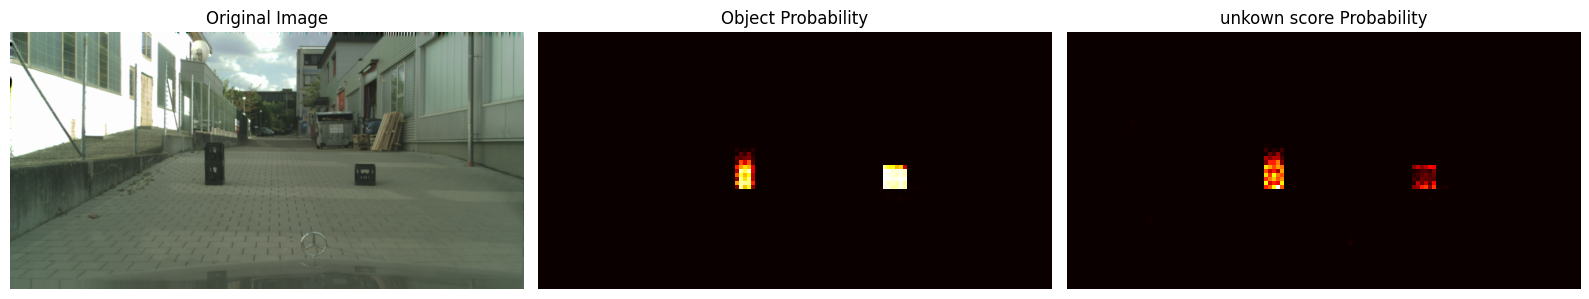

In [21]:
visualize_output(train_extra_loader,5)

# Fishscapes Benchmark

We need to downgrade the libraries and install additional library bdlb for this benchmark (it may ask to restart the session after the library installation)

In [16]:
!pip3 install --quiet tensorflow-gpu
!pip3 install --quiet --upgrade git+https://github.com/hermannsblum/bdl-benchmark.git

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Preparing metadata (setup.py) ... done


In [17]:
!pip install tensorflow-datasets==3.1.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.9.9
    Uninstalling tensorflow-datasets-4.9.9:
      Successfully uninstalled tensorflow-datasets-4.9.9


In [18]:
!pip install --force-reinstall -v protobuf==3.20.*

Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
  Obtaining dependency information for protobuf==3.20.* from https://files.pythonhosted.org/packages/8d/14/619e24a4c70df2901e1f4dbc50a6291eb63a759172558df326347dce1f0d/protobuf-3.20.3-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Removing file or directory /usr/local/lib/python3.11/dist-packages/google/_upb/
      Removing file or directory /usr/local/lib/python3.11/dist-packages/google/protobuf/
      Removing file or directory /usr/local/lib/python3.11/dist-packages/protobuf-5.29.5.dist-info/
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-m

## Imports for benchmark

In [9]:
import bdlb
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Download test set of Lost and Found

In [10]:
fs = bdlb.load(benchmark="fishyscapes", download_and_prepare=False)
fs.download_and_prepare('LostAndFound')
ds = tfds.load('fishyscapes/LostAndFound', split='validation')


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'wwwlehre.dhbw-stuttgart.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'wwwlehre.dhbw-stuttgart.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fishyscapes/LostAndFound/1.0.0.incomplete60TVRM/fishyscapes-validation.tfrecord


  0%|          | 0/100 [00:00<?, ? examples/s]

Computing statistics...:   0%|          | 0/1 [00:00<?, ? split/s]

0 examples [00:00, ? examples/s]

Dataset fishyscapes downloaded and prepared to /root/tensorflow_datasets/fishyscapes/LostAndFound/1.0.0. Subsequent calls will reuse this data.


In [37]:
def estimator_unknown_objectness_scores_normalized(image):

    test = image
    if isinstance(image, tf.Tensor):
        img_np = image.numpy()
        img_np = (img_np * 255).astype(np.uint8)
        image = Image.fromarray(img_np)
    transform = T.Compose([
    T.Resize((512, 1024)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ])

    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.amp.autocast(device):
      sem_logits = model(img_tensor)

    out_obj = torch.sigmoid(sem_logits[:, 20:21, :, :])
    sem_probs = torch.sigmoid(sem_logits[:, :20, :, :])

    sem_probs_inv = 1 - sem_probs
    sem_logits_inv_prod = sem_probs_inv.prod(dim=1, keepdim=True)
    unknown_objectness_score = sem_logits_inv_prod.squeeze()  * out_obj.squeeze()

    unk_score = unknown_objectness_score
    unk_score_norm = (unk_score - unk_score.min()) / (unk_score.max() - unk_score.min() + 1e-8)
    unk_score_norm = F.interpolate(
        unk_score_norm.unsqueeze(0).unsqueeze(0),
        size=(1024, 2048),
        mode='bilinear',
        align_corners=False
    ).squeeze()

    unk_score_norm = unk_score_norm.detach().cpu().numpy()
    unknown_objectness_score = tf.convert_to_tensor(unk_score_norm, dtype=tf.dtypes.float32)
    return unknown_objectness_score

In [38]:
metrics = fs.evaluate(estimator_unknown_objectness_scores_normalized, ds)


100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


In [39]:
print('My method achieved {:.2f}% AP {:.2f}% AUC'.format(100 * metrics['AP'],100 * metrics['auroc']))


My method achieved 21.57% AP 93.12% AUC
